<a href="https://colab.research.google.com/github/jahidhasan299/jahidhasan299-Deep-Learning-With-7-Real-Projects/blob/main/Handwritten_Digits_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

An autocoder is a neural network whose purpose is to code it's input into small dimensions and the result obtained to be able to reconstruct the input itself.

**Autoencoder's are made up of the union of the following two subnets:**

1.   Encoder
2.   Decoder

It's a loss function calculated as the distance between the amount of information loss between the compressed representation of the data and the data decompressed representation.

The keras functional API is the way to go fora defining complex models, such as multioutput models, directed acylic graphs or models with shared layes.

There's are 4 simple steps:
1.   Define the input: InputModel = input(shape=(784,))
2.   Add the encoder layer: EncoderLayer = Dense(32, activation="relu")(InputModel)
3. Add the decoder layer: DecoderLayer = Dense(784, activation="sigmoid")(EncoderLayer)
4. Instantiate a model: AutoencoderModel = Model(InputModel, DecoderLayer)





# Autoencoder Implementation
The encoder is a function that compress the index x, info a low dimentional latent vector, 1. This vector represents the important features of the input distribution. The decoder will try to recover the orginal input from the latent vector in the form of x~.

x -> Encoder (f(x)) -> latent vector (z) -> (g(z)) -> x~

To out the auto encoder into context, x can be MNIST digit that has a dimension of 28 * 28 * 1 = 784. The encoder tranforms the input into a low-dimensional z that can be a 16-dimension latent vector. The decoder will attemp to recover the input in the form of x~ from z.

Every MNIST digit z appears to be very similar to x~.

7 -> Encoder (f(x)) -> 16-dim (z) -> decoder (g(z)) -> 7


# Import the nescessary library and data

In [1]:
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as k
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load MNIST Dataset
(x_train, _), (x_test, _) = mnist.load_data()
# Reshape to (28, 28,1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train,[-1, image_size, image_size, 1])
x_test  = np.reshape(x_test,[-1, image_size, image_size, 1])
# Convert the image pixel from 0-255 to 0-1
x_train = x_train.astype('float32') / 255
x_test  = x_test.astype('float32') / 255


11501568/11490434 [==============================] - 0s 0us/step


In [3]:
#network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
# encode / decode number of CNN layers and filters per layer
layer_filters = [32,64]
# build autoencoder model
# The first we will build the encoder model
inputs = Input(shape=input_shape, name= 'encoder_input')
x = inputs
#stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
  x = Conv2D(
      filters=filters,
      kernel_size = kernel_size,
      activation='relu',
      strides= 2,
      padding='same'
  )(x)

In [4]:
#shape info needed to build decoder mode
# so we do not do hand computation
# The input to the decoder's first
# Conv2DTranspose will have this shape
# shape is (7,7,64) which is processed by the decoder back to (28,28,1)
shape = k.int_shape(x)

In [ ]:
#generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
# instantiate encoder model
encoder = Model(inputs,latent,name='encoder')
encoder.summary()
plot_model(encoder,to_file='encoder.png',show_shapes=True)

In [6]:
# Build the decoder model
latent_inputs = Input(shape=(latent_dim, ), name='decoder_input')
# use the shape(7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)


In [7]:
#stack of Conv2DTransepose (64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
  x = Conv2DTranspose(
      filters=filters,
      kernel_size = kernel_size,
      activation='relu',
      strides= 2,
      padding='same'
  )(x)

In [8]:
# reconstuct the input
outputs = Conv2DTranspose(
    filters=1,
    kernel_size = kernel_size,
    activation='sigmoid',
    padding='same',
    name = 'decoder_output'
)(x)

In [ ]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name = 'decoder')
decoder.summary()

In [ ]:
plot_model(decoder, to_file='decoder.png', show_shapes=True)

In [ ]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)),name='autoencoder')
autoencoder.summary()

In [ ]:
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)


In [13]:
# Mean square error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')
# Train the autoencoder model
autoencoder.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=1, batch_size=batch_size)

1875/1875 [==============================] - 24s 8ms/step - loss: 0.0213 - val_loss: 0.0106


In [14]:
# Predict the autoencoder output from the test data
x_decoded = autoencoder.predict(x_test)

Display the first 8 test input and decoded input

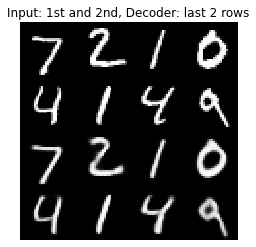

In [15]:
imgs = np.concatenate([x_test[:8],x_decoded[:8]])
imgs = imgs.reshape(4,4, image_size, image_size)
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st and 2nd, Decoder: last 2 rows')
plt.imshow(imgs,interpolation='none', cmap='gray')
plt.savefig('input_and_deocded.png')
plt.show()

Example of autoencoder model on MNIST dataset using 2dim latent The autoencoder forces the encoder to discover 2-dim latent vector that the decoder can recover the original input. The 2-dim latent vector is projected on 2D space to analyze the distribution of codes in the latent space. The latent space can be navigated by vaying the values of latent vetor to produce new MNIST digits.

The autoencoder has modular disign. The encoder, decoder and autoencoder are 3 models that share weights. For example, after training the autoencoder, the encoder can be used to genarate latent vectors of input data for low-dim visualization like PCA or TSNE.

In [16]:
from __future__ import absolute_import, division, print_function
import os

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten_2 (Flatten)         (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 2)                 6274      
                                                                 
Total params: 25,090
Trainable params: 25,090
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
______________________________________

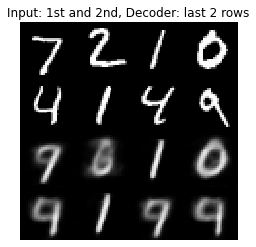

NameError: ignored

In [22]:
def plot_result(models, data, batch_size=32, model_name='autoencoder_2dim'):
  encoder, decoder = models
  x_test, y_test = data
  xmin = ymin = -4
  xmax = ymax = +4
  os.makedurs(model_name,exist_ok=True)
  filename = os.path.join(model_name, "latent2dim.png")
  z = encoder.predict(x_test, batch_size=batch_size)
  plt.figure(figsize=(12,10))
  axes = plt.gca()
  axes.set_xlim([xmin, xmax])
  axes.set_ylim([ymin, ymax])
  z = z[0::2]
  y_test = y_test[0::2]

  plt.scatter(z[:, 0], z[:,1], marker="")
  for i, digit in enumerate(y_test):
    axes.annotate(digit,(z[i, 0], z[i, 1]))
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()
    filename = os.path.join(model_name, "digits_over_latent.png")
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size*n, digit_size*n))
    grid_x = np.linspace(xmin,xmax, n)
    grid_y = np.linspace(ymin,ymax, n)[::-1]

    for i, yi, in enumerate(grid_y):
      for j, xi, in enumerate(grid_x):
        z = np.array([[xi,yi]])
        x_decoded = decoder.predict(z)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i*digit_size: (i+1) * digit_size,j*digit_size: (j+1) * digit_size] = digit
    plt.figure(figsize=(10,10))
    start_range = digit_size//2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)

    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xlabel("x[0]")
    plt.ylabel("x[1]")
    plt.imshow(figure, cmap="Grey_r")
    plt.savefig(filename)
    plt.show()
(x_train, _), (x_test, _) = mnist.load_data()
image_size = x_train.shape[1]
x_train = np.reshape(x_train,[-1, image_size, image_size, 1])
x_test  = np.reshape(x_test,[-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test  = x_test.astype('float32') / 255
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 2
layer_filters = [32,64]
inputs = Input(shape=input_shape, name= 'encoder_input')
x = inputs
for filters in layer_filters:
  x = Conv2D(filters=filters,kernel_size = kernel_size,activation='relu',strides= 2,padding='same')(x)
shape = k.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
encoder = Model(inputs,latent,name='encoder')
encoder.summary()
plot_model(encoder,to_file='encoder.png',show_shapes=True)
latent_inputs = Input(shape=(latent_dim, ), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for filters in layer_filters[::-1]:
  x = Conv2DTranspose(filters=filters,kernel_size = kernel_size,activation='relu',strides= 2,padding='same')(x)
outputs = Conv2DTranspose(filters=1,kernel_size = kernel_size,activation='sigmoid',padding='same',name='decoder_output')(x)
decoder = Model(latent_inputs, outputs, name = 'decoder')
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True) # autoencoder = encoder + decoder
autoencoder = Model(inputs, decoder(encoder(inputs)),name='autoencoder')
autoencoder.summary()
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
autoencoder.compile(loss='mse',optimizer='adam')
autoencoder.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=2, batch_size=batch_size)
x_decoded = autoencoder.predict(x_test)
imgs = np.concatenate([x_test[:8],x_decoded[:8]])
imgs = imgs.reshape(4,4, image_size, image_size)
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st and 2nd, Decoder: last 2 rows')
plt.imshow(imgs,interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()
models = (encoder, decoder)
data = (x_test, y_test)
plot_result(models, data, batch_size=batch_size, model_name="autoencoder_2dim")

# Image Denoising autoencoders implementaion

In [8]:
# Genarate corrupted MNIST images by adding noise with normal dist cetered at 0.5 and std = 0.5 
noise = np.random.normal(loc = 0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc = 0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise
# add noise may exceed normalized pixel value > 1.0 and 0.0
x_train_noisy  = np.clip(x_train_noisy, 0., 1.)
x_test_noisy  = np.clip(x_test_noisy, 0., 1.)
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
# encoder / decoder number of CNN layers and filters per layer
layer_filters = [32,64]

In [12]:
# build the encoder model
inputs = Input(shape=input_shape, name= 'encoder_input')
x = inputs

# stack of Conv2D (32)-Conv@D(64)
for filters in layer_filters:
  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)
shape = k.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vertor')(x)
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten_4 (Flatten)         (None, 3136)              0         
                                                                 
 latent_vertor (Dense)       (None, 16)                50192     
                                                                 
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


In [13]:
latent_inputs = Input(shape=(latent_dim, ), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for filters in layer_filters[::-1]:
  x = Conv2DTranspose(filters=filters,kernel_size = kernel_size,activation='relu',strides= 2,padding='same')(x)
outputs = Conv2DTranspose(filters=1,kernel_size = kernel_size,activation='sigmoid',padding='same',name='decoder_output')(x)
decoder = Model(latent_inputs, outputs, name = 'decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 3136)              53312     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 decoder_output (Conv2DTrans  (None, 28, 28, 1)        289 

In [14]:
autoencoder = Model(inputs, decoder(encoder(inputs)),name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                69008     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         108993    
                                                                 
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


In [15]:
autoencoder.compile(loss='mse',optimizer='adam')
autoencoder.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=2, batch_size=batch_size)

Epoch 1/2
1875/1875 [==============================] - 24s 8ms/step - loss: 0.0214 - val_loss: 0.0105
Epoch 2/2
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0098 - val_loss: 0.0090


In [17]:
# Predict the autoencoder output from currupted test images
x_decoded = autoencoder.predict(x_test)

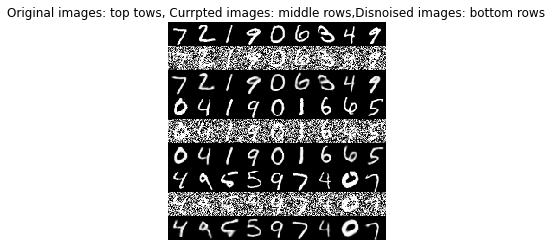

In [21]:
from PIL import Image
rows, cols = 3, 9
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows*3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows*3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs*255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top tows, ' 'Currpted images: middle rows,' 'Disnoised images: bottom rows')
plt.imshow(imgs, interpolation='none',cmap='gray')
Image.fromarray(imgs).save('Currpted_and_Denoised.png')
plt.show()

The noise added is a Gaussian distribution with a mean of 0.5 and standard deviation of 0.5.